# Writing an GAN: The Old Way

<a href='https://colab.research.google.com/github/zurutech/gans-from-theory-to-production/blob/master/2.%20GANs%20in%20Tensorflow/2.1.%20Writing%20a%20GAN%20from%20scratch%20-%20the%20old%20way.ipynb'>
    <img align="left" src='https://cdn-images-1.medium.com/max/800/1*ZpNn76K98snC9vDiIJ6Ldw.jpeg'></img>
</a>

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Writing-an-GAN-from-scratch:-The-Old-Way" data-toc-modified-id="Writing-an-GAN-from-scratch:-The-Old-Way-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Writing an GAN from scratch: The Old Way</a></span><ul class="toc-item"><li><span><a href="#Tensorflow:-nodes'-scope" data-toc-modified-id="Tensorflow:-nodes'-scope-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Tensorflow: nodes' scope</a></span></li><li><span><a href="#What-does-a-GAN-learn?" data-toc-modified-id="What-does-a-GAN-learn?-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>What does a GAN learn?</a></span></li><li><span><a href="#Input-data" data-toc-modified-id="Input-data-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Input data</a></span></li><li><span><a href="#Generator-and-discriminator-networks" data-toc-modified-id="Generator-and-discriminator-networks-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Generator and discriminator networks</a></span></li><li><span><a href="#Define-input-and-instantiate-networks" data-toc-modified-id="Define-input-and-instantiate-networks-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Define input and instantiate networks</a></span></li><li><span><a href="#The-loss-function-and-the-training-procedure" data-toc-modified-id="The-loss-function-and-the-training-procedure-1.6"><span class="toc-item-num">1.6&nbsp;&nbsp;</span>The loss function and the training procedure</a></span><ul class="toc-item"><li><span><a href="#Discriminator-loss-function" data-toc-modified-id="Discriminator-loss-function-1.6.1"><span class="toc-item-num">1.6.1&nbsp;&nbsp;</span>Discriminator loss function</a></span></li><li><span><a href="#Generator-loss-function" data-toc-modified-id="Generator-loss-function-1.6.2"><span class="toc-item-num">1.6.2&nbsp;&nbsp;</span>Generator loss function</a></span></li></ul></li><li><span><a href="#Gradient-ascent" data-toc-modified-id="Gradient-ascent-1.7"><span class="toc-item-num">1.7&nbsp;&nbsp;</span>Gradient ascent</a></span><ul class="toc-item"><li><span><a href="#Visualize-training" data-toc-modified-id="Visualize-training-1.7.1"><span class="toc-item-num">1.7.1&nbsp;&nbsp;</span>Visualize training</a></span></li><li><span><a href="#Advantages-and-disadvantages" data-toc-modified-id="Advantages-and-disadvantages-1.7.2"><span class="toc-item-num">1.7.2&nbsp;&nbsp;</span>Advantages and disadvantages</a></span></li></ul></li></ul></li><li><span><a href="#Bonus-exercise:-converting-it-to-a-Conditional-GAN" data-toc-modified-id="Bonus-exercise:-converting-it-to-a-Conditional-GAN-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Bonus exercise: converting it to a Conditional GAN</a></span></li></ul></div>

## Writing an GAN from scratch: The Old Way

Tensorflow allows us to define computational graphs. We can hence describe both the generator $G$ and the discriminator $D$, just like two interacting subgraphs.

A tensorflow specific feature that we have to take into account when we want to define a GAN in the "old" way (aka without using a `tf.estimator`) is the node's scope.

### Tensorflow: nodes' scope

Every node (variable and op) in the computational graph has a unique name. The naming system of tensorflow works like a filesystem directory structure:

```
/root/tree/leaf_1
/root/tree/leaf_2
```

In this case, the scope of both `leaf_1` and `leaf_2` is `/root/tree`. Obviously, under the same scope is **not** possibile to have 2 nodes with the same name.

When describing the discriminator, we'll need to feed to the network both the real and the generated samples. We could do this in two different ways:

1. Manually creating the input batches with the real and the generated sample concatenated along the first dimension and do the same for the labels.
2. Exploit the `tf.variable_scope` `reuse` feature, that allow us to define two different graphs that shares the same variables and use them to separetely feed the real and the generated data.

We're going to use this second option because it's easier to use and understand (and more elegant).

### What does a GAN learn?

The aim of the GAN we're going to implement is to learn a certain **data distribution** present in the training set.

The following exaple will guide you trough the required steps to build a GAN from scratch using Tensorflow while giving you a **visual intuition** of what a GAN learns during it's training process.

### Input data

In order to give a meaningful example, we're going to generate and visualize the distribution that has to be learn.

$$ \mathcal{N}(\mu = 10, \sigma = 0.1) $$
Our **target** distribution is a Gaussian distribution centered in $10$ a with a small variance of $0.1$

We're going to use Tensorflow itself to **sample datapoints** from this distribution in order to build our training set.

In [1]:
# Required inclues to create the GAN and to visualize the data
%matplotlib inline

import os
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from IPython import display
import pylab as pl

Tensorflow needs to first build a graph and than place it into a `Session` object. This object represents the computation executed on a *physical device* (GPU/CPU/TPU). So, in order to use tensorflow to generate the input data, I'm going to create an `InteractiveSession` (that's just a normal session, that installs itself as the default session of this environment)

In [2]:
sess = tf.InteractiveSession()

Let's sample `dataset_size` datapoints from the target distribtuion: this will be our training set. Once sampled, we just plot the histogram of the datapoints

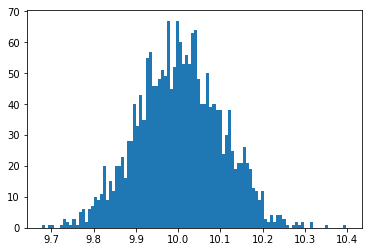

In [3]:
dataset_size = 2000
z = tf.random_normal(mean=10., shape=(), stddev=0.1, dtype=tf.float32)

z_samples = [sess.run(z) for _ in range(dataset_size)]

counts, bin, ignored = plt.hist(z_samples, 100)

### Generator and discriminator networks

The **generator** $G$ network architecture is **completely arbitrary**: practice suggests that a simple layer with just 2 fully connected layers and a single linear layer at the output is enough for leraning such a simple task.

The **discriminator** $D$ network architecture is **completely arbitrary** too. The only thing that's mandatory is the use of the **linear activation** in the single output neuron.

This is due to the fact that we're going to use a tensorflow built-in loss function to train this classifierf and this function requires an "unscaled logits" as input vector, aka a linear output.

In [4]:
def generator(inputs):
    """generator network.
    Args:
        inputs: a (None, latent_space_size) tf.float32 tensor
    Returns:
        G: the generator output node
    """
    with tf.variable_scope("generator"):
        fc1 = tf.layers.dense(inputs, units=64, activation=tf.nn.elu, name="fc1")
        fc2 = tf.layers.dense(fc1, units=64, activation=tf.nn.elu, name="fc2")
        G = tf.layers.dense(fc1, units=1, name="G")
    return G
    
def disciminator(inputs, reuse=False):
    """discriminator network.
    Args:
        inputs: a (None, 1) tf.float32 tensor
        reuse: python boolean, if we expect to reuse (True) or declare (False) the variables
    Returns:
        D: the discriminator output node
    """
    with tf.variable_scope("discriminator", reuse=reuse):
        fc1 = tf.layers.dense(inputs, units=32, activation=tf.nn.elu, name="fc1")
        D = tf.layers.dense(fc1, units=1, name="D")
    return D

**Note**: we definied both the discriminator and the generator **under different scopes**, for the disciminator we also passed the **reuse** parameter to `tf.variable_scope`. This will help us to pass to the discriminator the generated and the real data in a elegant manner.

### Define input and instantiate networks

So far we just defined the $G$ and $D$ architecture, without creating any instance of them.

What's missing is to define the shape of the inputs (we'll use `tf.placeholder`) and define the computational graph.

What we're going to do the in the next few lines is to **exploit** the `reuse` parameter of `tf.variable_scope` to **define the discriminator parameters once**, but define two different computational graphs that **share** the same parameters.

1. A graph for the real_input $D(x), x \sim p_{data}$
1. A graph for the generated data $D(G(z))$

For the generator, instead, the definition is straightforward: just accept noise as input and produce the generated output.

In [5]:
# Define the real input, a batch of values sampled from the real data (our N(10,0.1) distribution)
real_input = tf.placeholder(tf.float32, shape=(None,1))
# Define the discriminator network and its parameters
D_real = disciminator(real_input)

# Arbitrary set the shape of the noise prior (vector of 100 values sampled from a N(0,1) distribution)
latent_space_size = 100
# Define the input noise shape and define the generator
input_noise = tf.placeholder(tf.float32, shape=(None,latent_space_size))
G = generator(input_noise)

# now that we have defined the generator and G is the generator output, we can define another discriminator graph
# that will **reuse** the varibles defined previously
D_fake = disciminator(G, True)

### The loss function and the training procedure

As the theory describes, the training procedure is the **alternating** execution of training steps. In the next few lines we're going to implement the **non saturating** version of the value function.

As described above, the output layers of the 2 models have **linear output** because we're going to use the `tf.nn.sigmoid_cross_entropy_with_logits` that wants unscaled logits as input.

In practice, the `tf.nn.sigmoid_cross_entropy_with_logits` computes the binary cross entropy between two distributions:

1. the learned distribution, that assigns a probability the a certain class, that's why the function applies the **sigmoid**  $\sigma$ function to the output neuron, in order to consider the output a probability (range [0-1])
2. the conditional empirical distribution over class labels (a probability distribution where the probability of the current observed positive sample is 1 and is 0 for any other class)

$$ \mathcal{L}_{BCE} = y - \log(\hat{y}) - (1 - y)\log(1 - \hat{y}) $$

#### Discriminator loss function

Given the labels for the positive class and the nevative class to be 1 and 0 respectively, the loss becomes the sum of 2 BCE:

$$ \frac{1}{m} \sum_{i=1}^{m}- \log \sigma(D(x^{(i)})) + \frac{1}{m} \sum_{i=1}^{m} - \log(1 - \sigma(D(G(z^{(i)})) $$

The loss function is the binary cross entropy between the class of the real samples (label 1) and the class of the generated samples (label 0).

In [6]:
D_loss_real = tf.reduce_mean(
    tf.nn.sigmoid_cross_entropy_with_logits(logits=D_real, labels=tf.ones_like(D_real))
)

D_loss_fake = tf.reduce_mean(
    tf.nn.sigmoid_cross_entropy_with_logits(logits=D_fake, labels=tf.zeros_like(D_fake))
)

D_loss = D_loss_real + D_loss_fake

#### Generator loss function
$$ -\frac{1}{m} \sum_{i=1}^{m} \sigma(\log(D(G(z)))) $$

The loss function is just the binary cross entropy between the log probability of the generated images and the distribution of the real images (label 1)

In [7]:
G_loss = tf.reduce_mean(
    tf.nn.sigmoid_cross_entropy_with_logits(logits=D_fake, labels=tf.ones_like(D_fake))
)

### Gradient ascent

In order to train 2 different networks one next to the other, we have to to something a little bit unusual when using tensorflow.

In the majority of the examples online, you'll find the usage of a single `tf.train.*Optimizer` used to train all the variables (gathered using `tf.trainable_variables()` or just falling back on the default behaviour).

When training a GAN, instead, we want to **specify the variables we want to train on each step**, and hence define also more than one optimzer.

Having correctly specified the scope of the generator and of the descriminator, we can be sure that the generator and the disciminator variable are in the `/generator` and `/discriminator` scope respectively.

Hence, we can use `tf.trainable_variables` `scope` parameter to gather all the variables declared under the specified scope.

*tip*: if the optimizer is the same in both $G$ and $D$ you can use the same optimizer, just by calling the `.minimize` method on different sets of variables. The choose of the optimizer is an additional hyperparameter of the GAN training.

In [8]:
# Gather D and G variables
D_vars = tf.trainable_variables(scope="discriminator")
G_vars = tf.trainable_variables(scope="generator")

# Define the optimizers and the train operations
train_D = tf.train.AdamOptimizer(1e-5).minimize(D_loss, var_list=D_vars)
train_G = tf.train.AdamOptimizer(1e-5).minimize(G_loss, var_list=G_vars)

Now we're ready to play the game.

The training process is **exactly** the one described in the GAN paper.

Just a note about the **discriminator train**: we're passing the noise vector even in this step, this is required because when calling `train_D` we're calling `D_loss` that requires the `fake_data` generated by $G(z)$.

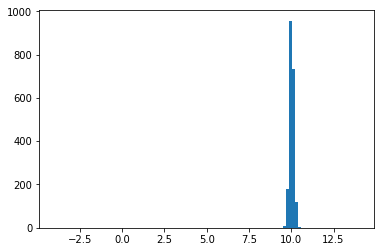

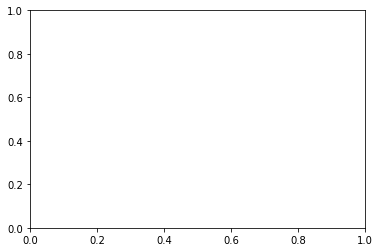

In [9]:
# Add a dimension to the training set, in order to get the correct shape for training (being compatible with the
# shape of the placeholder `input_noise`).
# Passing from a vector of `(dataset_size,)` shape to a batch with shape `(dataset_size, 1)`

real_data = np.expand_dims(np.array(z_samples),1) # mu=10, mean=0.1, training_set size samples
sess.run(tf.global_variables_initializer())

# Let's play the min-max game

if not os.path.exists("./gif/"):
     os.makedirs("./gif/")

for step in range(100000):
    noise_vector = np.random.normal(loc=0, scale=1, size=(dataset_size, latent_space_size))
    
    # Train the disciminator
    _, d_loss_value = sess.run([train_D, D_loss], feed_dict={real_input: real_data, input_noise: noise_vector})
    
    # Train the generator
    _, g_loss_value = sess.run([train_G, G_loss], feed_dict={input_noise: noise_vector})
    
    if step % 100 == 0:
        print("G loss: ", g_loss_value, " D loss: ", d_loss_value, " step: ", step)
        
        # Sample 5000 values from the Generator and draw the histogram
        sampled = sess.run(G, feed_dict={input_noise: noise_vector})
        counts, bin, ignored = plt.hist(sampled, 100, range=(-4, 14))
        display.clear_output(wait=True)
        display.display(pl.gcf())
        plt.savefig("./gif/{}.png".format(step))
        plt.gca().clear()

#### Visualize training

Every 100 steps of train, we generated and saved an histogram of (`dataset_size`) data points.
In order to generate a nice animation of the learning process we can just use the `imagemagick` tool to merge all the images into a pretty cool gif of the learning process.
This gif shows you how the learning process learned to shift the initial random distribution to the correct value of $10$ and to adjust the variance in order to be close to the one of **target distribution**.

In [10]:
! convert -delay 20 -loop 0 $(ls gif/*.png | sort -V) gif/learning_gaussian.gif

![animation](gif/learning_gaussian.gif)

#### Advantages and disadvantages

Writing a GAN from scratch using only the plain old Tensorflow API is extremely helpful for learning how to correctly write a GAN, understand the theory behinds this tool and how to deal with the peculiarities of Tensorflow (scoping, graph definition, variable reuse, how to define the loss functions, ...)

However, this example could become extremely long and boring if we add:

- The dataset generation (using the Tensorfloe QueueRunner - manually handle multi threading)
- The logging: use `tf.summary.*` methods to log metrics + tf.Saver to log summaries
- The usage of `tf.Saver` to log the summaries and to save the trained model itself
- The data visualization in tensorbard
- The export of the model with the correct input definition in order to be ready for serving
- ...

In order to speed-up the development time, the tensorflow devs introduced the `tf.estimator`<sup>[1](#1)</sup> and `tf.data`<sup>[2](#1)</sup> API: an high level API that greatly simplifies machine learning programming. Estimators encapsulate the following actions:

- training
- evaluation
- prediction
- export for serving

While the `tf.data` API made the dataset generation extremely easy.

In the next chapter, we'll see how to use the `tf.estimator` and `tf.data` to create a dataset and to train a GAN.

We'll start with the definition of the data and of the discriminator.

## Bonus exercise: converting it to a Conditional GAN

Extending this simple GAN making it conditional can be a good test bench to check your understanding of the GAN theory explained in the first section.

Remeber that both $G$ and $D$ needs to be conditioned and that the train process is just the same game, plaied for every different condition.

Copy this notebook and try to condition this GAN in order to learn 2 different normal distributions.

- Condition `0`: generates $\mathcal{N}(10, 0.1)$
- Condition `1`: generates $\mathcal{N}(20, 0.2)$

A solution to this exersice can be found in the notebook: [BONUS - Conditional GAN from scratch](BONUS - Conditional GAN from scratch.ipynb).


---
<a id="1">[1]</a>: https://www.tensorflow.org/guide/estimators

<a id="2">[2]</a>: https://www.tensorflow.org/guide/datasets